In [ ]:
from sklearn.linear_model import Ridge
from sklearn import linear_model
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS, cluster_optics_dbscan, DBSCAN
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import math


priceData = pd.read_csv('all_stocks_5yr.csv')

processed = pd.DataFrame()
for stock in np.unique(priceData["Name"]):
    df = pd.DataFrame()
    df = priceData.loc[priceData['Name'] == stock][['date','close']]
    df = df.transpose()
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df = df.rename(index={'close': stock})
    processed = pd.concat([processed, df])
processed

date,2013-02-08,2013-02-11,2013-02-12,2013-02-13,2013-02-14,2013-02-15,2013-02-19,2013-02-20,2013-02-21,2013-02-22,2013-02-25,2013-02-26,2013-02-27,2013-02-28,2013-03-01,2013-03-04,2013-03-05,2013-03-06,2013-03-07,2013-03-08,2013-03-11,2013-03-12,2013-03-13,2013-03-14,2013-03-15,2013-03-18,2013-03-19,2013-03-20,2013-03-21,2013-03-22,2013-03-25,2013-03-26,2013-03-27,2013-03-28,2013-04-01,2013-04-02,2013-04-03,2013-04-04,2013-04-05,2013-04-08,...,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,2018-01-18,2018-01-19,2018-01-22,2018-01-23,2018-01-24,2018-01-25,2018-01-26,2018-01-29,2018-01-30,2018-01-31,2018-02-01,2018-02-02,2018-02-05,2018-02-06,2018-02-07
A,45.08,44.6,44.62,44.75,44.58,42.25,43.01,42.24,41.63,41.8,41.29,40.97,41.73,41.48,41.93,42.03,42.66,43.24,43.25,43.03,42.81,42.62,43,43.32,43.01,42.55,42,42.7,41.65,41.25,41.13,41.82,42.09,41.97,40.93,40.66,40.52,41.41,41.54,41.66,...,67,67.06,66.68,66.51,67.61,67.66,67.75,67.4,67.52,67.35,67.25,67.3,67.45,66.97,67.6,69.32,68.8,69.9,70.05,71.77,70.79,70.8,71.73,71.23,72.06,72.19,73.07,73.48,73.44,73.58,73.86,74.82,74.53,72.99,73.43,72.83,71.25,68.22,68.45,68.06
AAL,14.75,14.46,14.27,14.66,13.99,14.5,14.26,13.33,13.37,13.57,13.02,13.26,13.41,13.43,13.61,13.9,14.05,14.57,14.82,14.92,15.13,15.5,15.91,16.25,15.98,16.29,16.78,17.23,17,16.86,16.6,16.51,16.65,16.97,16.67,15.74,15.53,15.69,15.72,15.84,...,51.3,50.47,50.09,50.21,51.06,51.49,51.44,51.92,52.79,52.59,52.85,52.4,52.46,52.03,52.99,52.34,52.67,52.65,52.13,52.08,53.78,56.42,58.47,57.98,58.16,58.34,58.06,58.1,58.29,54.79,53.05,53.07,52.68,52.59,54.32,53.88,52.1,49.76,51.18,51.4
AAP,78.9,78.39,78.6,78.97,78.84,79,80.72,79.5,79.06,79.21,78.36,77.15,77.3,76.34,76.37,77.02,76.95,76.18,76.22,76.84,77.53,77.36,78.77,77.67,79.57,80.7,80.07,80.22,80.03,79.81,80.53,81.6,81.64,82.65,82.34,82.83,82.12,82.2,80.95,80.63,...,100.85,103.03,102.5,100.2,100.7,102.71,99.73,98.59,100.13,100.55,101.96,99.77,99.71,99.69,106.09,107.05,111,112.18,111.39,110.49,110.59,112.95,115.94,113.9,115.35,115.53,117.02,118.03,119.1,120.99,120.92,123.64,122.89,119.27,116.99,117.29,113.93,109.86,112.2,109.93
AAPL,67.8542,68.5614,66.8428,66.7156,66.6556,65.7371,65.7128,64.1214,63.7228,64.4014,63.2571,64.1385,63.5099,63.0571,61.4957,60.0071,61.5919,60.8088,61.5117,61.6742,62.5528,61.2042,61.1928,61.7857,63.3799,65.1028,64.9271,64.5828,64.6756,65.9871,66.2256,65.8765,64.5828,63.2371,61.2728,61.3988,61.7128,61.1028,60.4571,60.8871,...,172.67,171.7,172.27,172.22,173.97,176.42,174.54,174.35,175.01,175.01,170.57,170.6,171.08,169.23,172.26,172.23,173.03,175,174.35,174.33,174.29,175.28,177.09,176.19,179.1,179.26,178.46,177,177.04,174.22,171.11,171.51,167.96,166.97,167.43,167.78,160.5,156.49,163.03,159.54
ABBV,36.25,35.85,35.42,35.27,36.57,37.58,38.19,38.61,38.78,38.46,37.37,37.09,36.73,36.92,37.81,38.24,37.51,37.74,37.49,37.34,37.67,37.17,37.17,37.56,38.5,38.16,38.36,39.06,38.49,38.97,39.32,40.21,40.15,40.78,41.12,40.71,40.57,41.6,41.31,41.77,...,96.47,96.3,97.35,96.3,97.45,98.19,97.92,97.41,97.91,98.21,97.75,98.09,97.79,96.71,98.41,99.95,99.38,101.11,99.49,100.24,99.69,99.27,100.34,102.49,104.36,103.81,104.64,106.49,105.38,105.51,108.3,123.21,122.31,115.88,112.22,116.34,115.17,109.51,111.2,113.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XYL,27.09,27.46,27.95,28.26,28.47,28.28,28.76,27.96,27.68,27.79,27.02,27,27.47,27.5,27.49,27.49,28.45,29.34,28.4,28.43,28.76,28.53,28.47,28.71,28.96,28.78,28.44,28.51,28.56,28.44,27.73,27.69,27.29,27.56,27.25,27.22,27.12,27.72,27.6,2

# Lasso Linear Regression

In [ ]:
# First Pair
a = processed.loc[processed.index.isin(['AIZ'])]
b = processed.loc[processed.index.isin(['ECL'])]

a = a.to_numpy()
b = b.to_numpy()

In [ ]:
def spread(a,b):

  # Initialize variables 
  lowest_n = float("inf")
  best_degree = 0

  # Define training split for training and testing datasets
  training_split = int(a.size/5*4)

  # Split data into training and testing datasets
  training_a = a[0, 0:training_split]
  training_b = b[0, 0:training_split]
  testing_a = a[0, training_split:]
  testing_b = b[0, training_split:]

  # Add dimension to data for Fit function
  training_a = training_a[:, np.newaxis]
  testing_a = testing_a[:, np.newaxis]

  # Find the best degree for Regression
  for degree in range(1,10,1):

    # Change the dataset to polynomial form
    poly = PolynomialFeatures(degree = degree)
    poly_train_a = poly.fit_transform(training_a)
    poly_valid_a = poly.fit_transform(testing_a)

    # Perform Lasso regression
    lasso = linear_model.LassoCV(cv=10)
    lasso.fit(poly_train_a, training_b)

    # Calculate error 
    error = np.average((testing_b - lasso.predict(poly_valid_a))**2)

    # Find best degree 
    if error < lowest_n:
      best_degree = degree
      lowest_n = error

  # Train data again with the best degree
  poly = PolynomialFeatures(degree=best_degree)
  poly_train_a = poly.fit_transform(training_a)
  lasso = linear_model.LassoCV(cv=5)
  lasso.fit(poly_train_a, training_b)

  # Calculate mean and standard deviation of data
  b_pred = lasso.predict(poly_train_a)
  spread = training_b - b_pred
  spread_std = np.std(spread)
  spread_mean = np.mean(spread)
  
  # Change data to polynomial form
  a, b = np.log(a), np.log(b)
  a = a * np.ones((1,1))
  poly = PolynomialFeatures(degree = best_degree)
  a = a.T
  a = poly.fit_transform(a)

  # Calculate spread and Z Score of data
  spread = b - lasso.predict(a)
  z_score = (spread - np.mean(spread, axis=1))/spread_std

  return spread, z_score

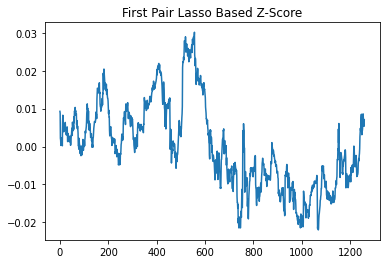

In [ ]:
 # Visualize First Lasso based z-score
spread, z_score = spread(a.astype(float), b.astype(float))
x = np.arange(1259)
plt.title('First Pair Lasso Based Z-Score')
plt.plot(x, z_score.T)
plt.show()

In [ ]:
# Second Pair
a2 = processed.loc[processed.index.isin(['MPC'])]
b2 = processed.loc[processed.index.isin(['PRU'])]

a2 = a2.to_numpy()
b2 = b2.to_numpy()

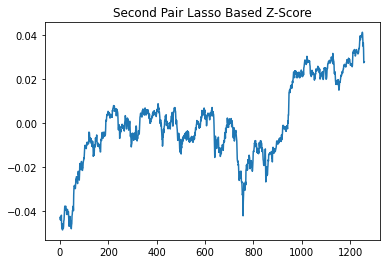

In [ ]:
# Visualize Second Lasso based z-score
spread2, z_score2 = spread(a2.astype(float), b2.astype(float))
x = np.arange(1259)
plt.title('Second Pair Lasso Based Z-Score')
plt.plot(x, z_score2.T)
plt.show()

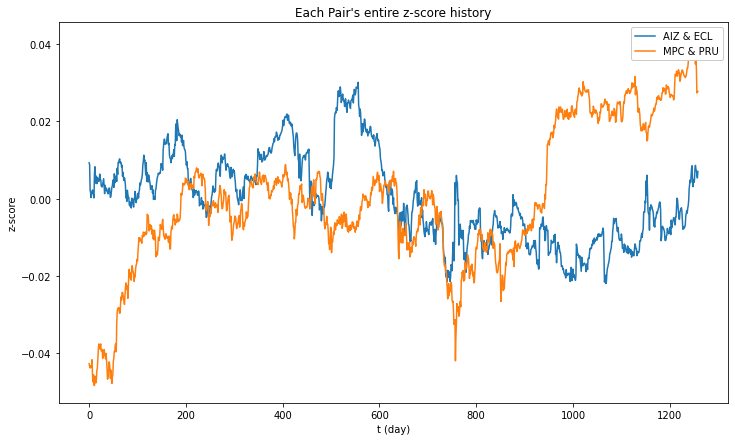

In [ ]:
z_score_history_list = np.zeros((1, 1))
z_score_history_list = np.append(z_score, z_score2, axis=0)

plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s entire z-score history')
plt.ylabel('z-score')
plt.xlabel('t (day)')
x = np.arange(z_score_history_list[0].shape[0])

plt.plot(x, z_score_history_list[0], label = 'AIZ & ECL')
plt.plot(x, z_score_history_list[1], label = 'MPC & PRU')
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_z_score.png')
plt.show()

with open('z_score_history.npy', 'wb') as outfile:
    np.save(outfile, z_score_history_list)

In [ ]:
class Backtesting():
    """
    Run the backtesting and track the total asset history
    
    This Backtesting method was adapted from a previous CS 4641 Grad project 
    for our undergrad application:
    https://daehkim.github.io/pair-trading/
    """

    def __init__(self, z_score_list, stop_loss=3, buy_z=0.01, sell_z=-0.01, 
                 total_money=100000):
        self.pairs_num = z_score_list.shape[0]
        self.total_time = z_score_list.shape[1] 
        self.stop_loss = stop_loss
        self.buy_z = buy_z
        self.sell_z = sell_z

        self.inverse_price = np.zeros((2 * self.pairs_num))
        self.total_stock = np.zeros((2 * self.pairs_num))
        self.total_inverse = np.zeros((2 * self.pairs_num))
        self.money_for_pair = int(total_money/self.pairs_num) * \
            np.ones((self.pairs_num))

    def trade_decision(self, z_score, pair_num):
        """
        Decide whether we will buy/sell the stock/inverse.
        It is decided by z-score.

        Args:
            z_score: scalar z_score value
            pair_num: pair's number
        Return:
            stock: buy(+1), sell(-1), stop_loss(-2)
            inverse: buy(+1), sell(-1), stop_loss(-2)
        """

        stop_loss = self.stop_loss
        buy_z = self.buy_z
        sell_z = self.sell_z
        total_stock = self.total_stock[2 * pair_num]
        total_inverse = self.total_inverse[2 * pair_num]
        stock, inverse = 0, 0

        # Need to sell everything to stop loss
        if z_score >= stop_loss or z_score <= -1*stop_loss:
            stock, inverse = -2, -2

        # If the z-score is over the buy_z, buy the stock a
        elif z_score >= buy_z and total_stock == 0:
            stock, inverse = 1, 0
        
        # If the z-score below sell_z, sell all the stocks to make profit 
        elif z_score <= sell_z and total_stock > 0:
            stock, inverse = -1, 0

        # If the z-score below -1 * buy_z, buy the inverse a
        elif z_score <= -1 * buy_z and total_inverse == 0:
            stock, inverse = 0, 1

        # If the z-score above -1 * sell_z, sell the inverse a to make profit
        elif z_score >= -1 * sell_z and total_inverse > 0:
            stock, inverse = 0, -1
        
        return stock, inverse


    def cal_trade_vol(self, stock_num, stock_signal, inv_signal, current_price):
        """
        Calculate the volume of trade we will trade

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_signal: Signal to trade the stock (+: buy, -: sell)
            inv_signal: Signal to trade the inverse (+: buy, -: sell)
            current_price: current price to calculate how many stock we will 
                trade
        Return:
            trade_stock_vol: Volume of stock to buy(+) or sell(-)
            trade_inverse_vol: Volume of inverse to buy(+) or sell(-)
        """

        # Initialization
        trade_stock_vol = 0
        trade_inverse_vol = 0

        # Calculate how much money we will use for this stock
        money_for_stock = self.money_for_pair[int(stock_num/2)] / 2

        # Sell the stock if the stock_signal < 0
        if stock_signal < 0:
            trade_stock_vol = -1 * self.total_stock[stock_num]

        # Buy the stock if the stock_signal > 0
        elif stock_signal > 0:
            trade_stock_vol = int(money_for_stock/current_price)

        # Sell the inverse if the inverse_signal < 0
        if inv_signal < 0:
            trade_inverse_vol = -1 * self.total_inverse[stock_num]

        # Buy the stock if the inverse_signal > 0
        elif inv_signal > 0:
            trade_inv_vol = int(money_for_stock/current_price)

        return trade_stock_vol, trade_inverse_vol
        
    def cal_result(self, stock_num, stock_vol, inverse_vol, prev_price, current_price):
        """
        Calculate the each stock's trade results

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_vol: Volume of stock to buy(+) or sell(-)
            inverse_vol: Volume of inverse to buy(+) or sell(-)
            prev_price: Price of the stock the day before.
            current_price: Price of the stock today.
        Return:
            total_asset: Sum of all the assets today.
        """

        # Update the price of current inverse
        if self.total_inverse[stock_num] > 0:
            change_ratio = (current_price - prev_price) / prev_price
            self.inverse_price[stock_num] = (1 - change_ratio) * self.inverse_price[stock_num]
        
        # Buy the stock
        if stock_vol > 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price

        # Sell the stock
        elif stock_vol < 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price
        
        # Buy the inverse
        if inverse_vol > 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * current_price
            self.inverse_price[stock_num] = current_price
        
        # Sell the inverse
        if inverse_vol < 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * self.inverse_price[stock_num]
            self.inverse_price[stock_num] = 0

        total_asset = (self.total_inverse[stock_num] * self.inverse_price[stock_num] + 
                          self.total_stock[stock_num] * current_price)

        return total_asset


    def backtesting(self, z_score_list, price_list):
        """
        Args:
            z_score_list: list of z-score history (NxT).
            price_list: list of price history (2NxT).
        Return:
            final asset history
        """

        total_asset = np.zeros((self.pairs_num, self.total_time))

        for t in range(self.total_time):
            for pair_num in range(self.pairs_num):
                stock_a_num = 2*pair_num
                stock_b_num = 2*pair_num+1
                z_score = z_score_list[pair_num]
            
                # Decide whether buy or sell stock a.
                stock_a, inverse_a = self.trade_decision(z_score[t], pair_num)
                stock_b = inverse_a
                inverse_b = stock_a

                # Calculate the buy/sell volume
                stock_a_vol, inverse_a_vol = self.cal_trade_vol(
                    stock_a_num, stock_a, inverse_a, price_list[stock_a_num][t])
                stock_b_vol, inverse_b_vol = self.cal_trade_vol(
                    stock_b_num, stock_b, inverse_b, price_list[stock_b_num][t])

                # Calculate the trade result
                total_asset[pair_num][t] += self.cal_result(stock_a_num, stock_a_vol, 
                                                  inverse_a_vol, 
                                                  price_list[stock_a_num][t-1], 
                                                  price_list[stock_a_num][t])
                
                total_asset[pair_num][t] += self.cal_result(stock_b_num, stock_b_vol,
                                                     inverse_b_vol, 
                                                     price_list[stock_b_num][t-1], 
                                                     price_list[stock_b_num][t])

                total_asset[pair_num][t] += self.money_for_pair[int(pair_num)]

        return total_asset

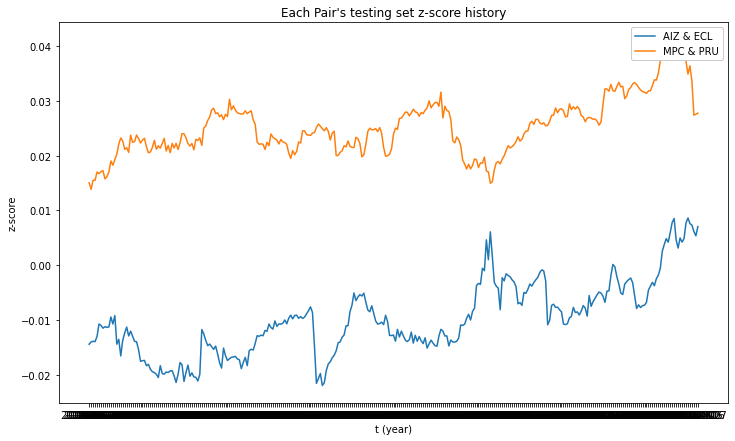

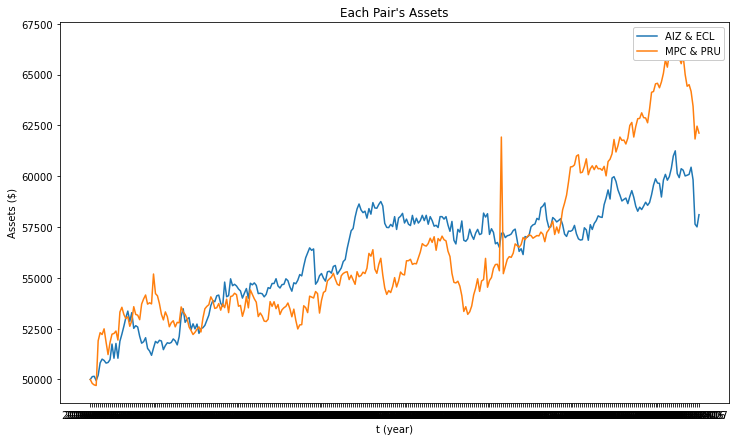

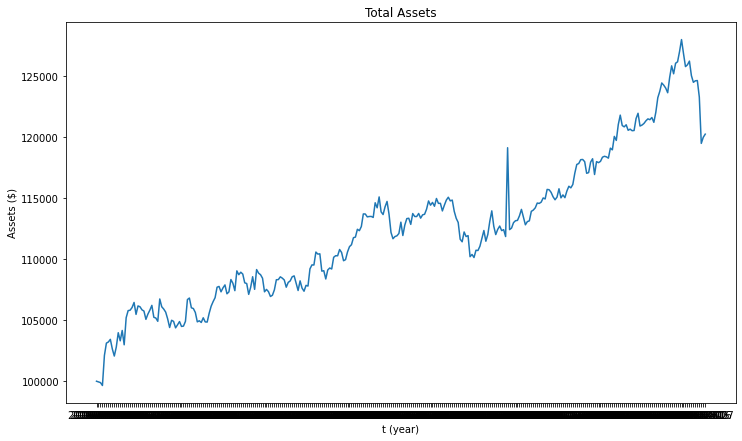

Total earning ratio: 1.2022337


In [ ]:
# Read the z-score history list.
with open('z_score_history.npy', 'rb') as infile:
    z_score_list = np.load(infile)
    z_score_list = z_score_list[:2]

# Remove the initial 700 data. We generate the z-score after 700 days.
# price_list = training_set_price.to_numpy()[:, 700:]

a1 = processed.loc[processed.index.isin(['AIZ'])].to_numpy()[0]
b1 = processed.loc[processed.index.isin(['ECL'])].to_numpy()[0]
a2 = processed.loc[processed.index.isin(['MPC'])].to_numpy()[0]
b2 = processed.loc[processed.index.isin(['PRU'])].to_numpy()[0]
price_list = np.stack((a1, b1,a2,b2), axis=0)


# Initial money is $100000.
initial_money = 100000

z_score_list = z_score_list[:,950:]
price_list = price_list[:,950:]

# Run the backtesting code
BT = Backtesting(z_score_list, total_money = initial_money)
asset_per_pair = BT.backtesting(z_score_list, price_list)

# Plot the graphs about results
x = processed.columns[950:]

# Graph about each pair's z-score
plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s testing set z-score history')
plt.ylabel('z-score')
plt.xlabel('t (year)')
# for i, pair in enumerate(pairs_list):
#     plt.plot(x, z_score_list[i], label=str(pair))

plt.plot(x, z_score_list[0], label = 'AIZ & ECL')
plt.plot(x, z_score_list[1], label = 'MPC & PRU')
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_z_score.png')
plt.show()

# Graph about each pair's assets
plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (year)')
# for i, pair in enumerate(pairs_list):
#     plt.plot(x, asset_per_pair[i], label=str(pair))

plt.plot(x, asset_per_pair[0], label = 'AIZ & ECL')
plt.plot(x, asset_per_pair[1], label = 'MPC & PRU')

plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_assets.png')
plt.show()

# Graph about total asset
plt.figure(figsize=(12, 7))
plt.title('Total Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (year)')
total_asset = np.sum(asset_per_pair, axis=0)
plt.plot(x, total_asset)
plt.savefig('total_assets.png')
plt.show()

# Calculate the total earning
total_earning_ratio = total_asset[-1] / initial_money
print("Total earning ratio: " + str(total_earning_ratio))

# Save the total assets
total_asset_history = pd.DataFrame(
    total_asset,
    index=x,
    columns=['total assets']
)
total_asset_history.to_csv('total_asset_history.csv', index=True)

# Ridge Regression

In [ ]:
# First Pair
a = processed.loc[processed.index.isin(['AIZ'])]
b = processed.loc[processed.index.isin(['ECL'])]

a = a.to_numpy()
b = b.to_numpy()

In [ ]:
def spreadRidge(a,b):

  # Initialize variables  
  lowest_n = float("inf")
  best_degree = 0
  
  # Define training split for training and testing datasets
  training_split = int(a.size/5*4)

  # Split data into training and testing datasets
  training_a = a[0, 0:training_split]
  training_b = b[0, 0:training_split]
  testing_a = a[0, training_split:]
  testing_b = b[0, training_split:]

  # Add dimension to data for Fit function
  training_a = training_a[:, np.newaxis]
  testing_a = testing_a[:, np.newaxis]

  # Find the best degree for Regression
  for degree in range(1,10,1):

    # Change the train datasets to polynomial form
    poly = PolynomialFeatures(degree = degree)
    poly_train_a = poly.fit_transform(training_a)
    poly_valid_a = poly.fit_transform(testing_a)

    # Perform Ridge regression
    ridge = linear_model.Ridge(alpha=1.0)
    ridge.fit(poly_train_a, training_b)

    # Calculate error
    error = np.average((testing_b - ridge.predict(poly_valid_a))**2)

    # Find best degree 
    if error < lowest_n:
      best_degree = degree
      lowest_n = error


  # Train data again with the best degree
  poly = PolynomialFeatures(degree=best_degree)
  poly_train_a = poly.fit_transform(training_a)
  ridge = linear_model.Ridge(alpha=1.0)
  ridge.fit(poly_train_a, training_b)

  # Calculate mean and standard deviation
  b_pred = ridge.predict(poly_train_a)
  spread = training_b - b_pred
  spread_std = np.std(spread)
  spread_mean = np.mean(spread)

  # Change data to polynomial form
  a, b = np.log(a), np.log(b)
  a = a * np.ones((1,1))
  poly = PolynomialFeatures(degree = best_degree)
  a = a.T
  a = poly.fit_transform(a)

  #Calculate spread and z score
  spread = b - ridge.predict(a)
  z_score = (spread - np.mean(spread, axis=1))/spread_std

 
  return spread, z_score

In [ ]:
spread, z_score = spreadRidge(a.astype(float), b.astype(float))

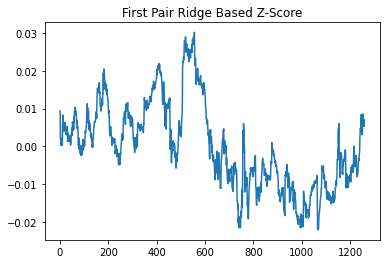

In [ ]:
x = np.arange(1259)
plt.title('First Pair Ridge Based Z-Score')
plt.plot(x, z_score.T)
plt.show()

In [ ]:
# Second Pair
a2 = processed.loc[processed.index.isin(['MPC'])]
b2 = processed.loc[processed.index.isin(['PRU'])]

a2 = a2.to_numpy()
b2 = b2.to_numpy()

In [ ]:
spread2, z_score2 = spreadRidge(a2.astype(float), b2.astype(float))

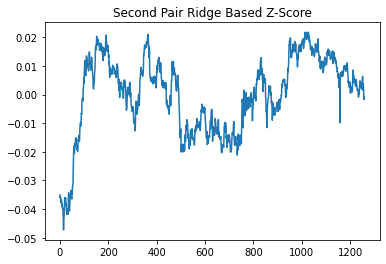

In [ ]:
x = np.arange(1259)
plt.title('Second Pair Ridge Based Z-Score')
plt.plot(x, z_score2.T)
plt.show()

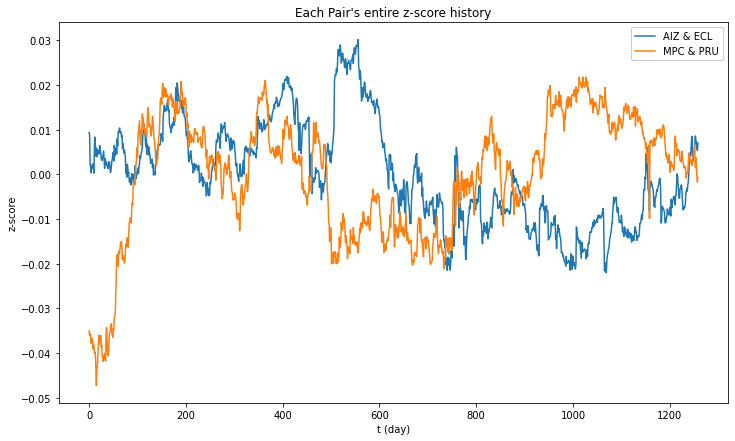

In [ ]:
z_score_history_list = np.zeros((1, 1))
z_score_history_list = np.append(z_score, z_score2, axis=0)

plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s entire z-score history')
plt.ylabel('z-score')
plt.xlabel('t (day)')
x = np.arange(z_score_history_list[0].shape[0])

plt.plot(x, z_score_history_list[0], label = 'AIZ & ECL')
plt.plot(x, z_score_history_list[1], label = 'MPC & PRU')
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_z_score.png')
plt.show()

with open('z_score_history.npy', 'wb') as outfile:
    np.save(outfile, z_score_history_list)

In [ ]:
class Backtesting():
    """
    Run the backtesting and track the total asset history

    This Backtesting method was adapted from a previous CS 4641 Grad project 
    for our undergrad application:
    https://daehkim.github.io/pair-trading/
    """

    def __init__(self, z_score_list, stop_loss=3, buy_z=0.01, sell_z=-0.01, 
                 total_money=100000):
        self.pairs_num = z_score_list.shape[0]
        self.total_time = z_score_list.shape[1] 
        self.stop_loss = stop_loss
        self.buy_z = buy_z
        self.sell_z = sell_z

        self.inverse_price = np.zeros((2 * self.pairs_num))
        self.total_stock = np.zeros((2 * self.pairs_num))
        self.total_inverse = np.zeros((2 * self.pairs_num))
        self.money_for_pair = int(total_money/self.pairs_num) * \
            np.ones((self.pairs_num))

    def trade_decision(self, z_score, pair_num):
        """
        Decide whether we will buy/sell the stock/inverse.
        It is decided by z-score.

        Args:
            z_score: scalar z_score value
            pair_num: pair's number
        Return:
            stock: buy(+1), sell(-1), stop_loss(-2)
            inverse: buy(+1), sell(-1), stop_loss(-2)
        """

        stop_loss = self.stop_loss
        buy_z = self.buy_z
        sell_z = self.sell_z
        total_stock = self.total_stock[2 * pair_num]
        total_inverse = self.total_inverse[2 * pair_num]
        stock, inverse = 0, 0

        # Need to sell everything to stop loss
        if z_score >= stop_loss or z_score <= -1*stop_loss:
            stock, inverse = -2, -2

        # If the z-score is over the buy_z, buy the stock a
        elif z_score >= buy_z and total_stock == 0:
            stock, inverse = 1, 0
        
        # If the z-score below sell_z, sell all the stocks to make profit 
        elif z_score <= sell_z and total_stock > 0:
            stock, inverse = -1, 0

        # If the z-score below -1 * buy_z, buy the inverse a
        elif z_score <= -1 * buy_z and total_inverse == 0:
            stock, inverse = 0, 1

        # If the z-score above -1 * sell_z, sell the inverse a to make profit
        elif z_score >= -1 * sell_z and total_inverse > 0:
            stock, inverse = 0, -1
        
        return stock, inverse


    def cal_trade_vol(self, stock_num, stock_signal, inv_signal, current_price):
        """
        Calculate the volume of trade we will trade

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_signal: Signal to trade the stock (+: buy, -: sell)
            inv_signal: Signal to trade the inverse (+: buy, -: sell)
            current_price: current price to calculate how many stock we will 
                trade
        Return:
            trade_stock_vol: Volume of stock to buy(+) or sell(-)
            trade_inverse_vol: Volume of inverse to buy(+) or sell(-)
        """

        # Initialization
        trade_stock_vol = 0
        trade_inverse_vol = 0

        # Calculate how much money we will use for this stock
        money_for_stock = self.money_for_pair[int(stock_num/2)] / 2

        # Sell the stock if the stock_signal < 0
        if stock_signal < 0:
            trade_stock_vol = -1 * self.total_stock[stock_num]

        # Buy the stock if the stock_signal > 0
        elif stock_signal > 0:
            trade_stock_vol = int(money_for_stock/current_price)

        # Sell the inverse if the inverse_signal < 0
        if inv_signal < 0:
            trade_inverse_vol = -1 * self.total_inverse[stock_num]

        # Buy the stock if the inverse_signal > 0
        elif inv_signal > 0:
            trade_inv_vol = int(money_for_stock/current_price)

        return trade_stock_vol, trade_inverse_vol
        
    def cal_result(self, stock_num, stock_vol, inverse_vol, prev_price, current_price):
        """
        Calculate the each stock's trade results

        Args:
            stock_num: Personal number to distinguish the stocks
            stock_vol: Volume of stock to buy(+) or sell(-)
            inverse_vol: Volume of inverse to buy(+) or sell(-)
            prev_price: Price of the stock the day before.
            current_price: Price of the stock today.
        Return:
            total_asset: Sum of all the assets today.
        """

        # Update the price of current inverse
        if self.total_inverse[stock_num] > 0:
            change_ratio = (current_price - prev_price) / prev_price
            self.inverse_price[stock_num] = (1 - change_ratio) * self.inverse_price[stock_num]
        
        # Buy the stock
        if stock_vol > 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price

        # Sell the stock
        elif stock_vol < 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price
        
        # Buy the inverse
        if inverse_vol > 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * current_price
            self.inverse_price[stock_num] = current_price
        
        # Sell the inverse
        if inverse_vol < 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * self.inverse_price[stock_num]
            self.inverse_price[stock_num] = 0

        total_asset = (self.total_inverse[stock_num] * self.inverse_price[stock_num] + 
                          self.total_stock[stock_num] * current_price)

        return total_asset


    def backtesting(self, z_score_list, price_list):
        """
        Args:
            z_score_list: list of z-score history (NxT).
            price_list: list of price history (2NxT).
        Return:
            final asset history
        """

        total_asset = np.zeros((self.pairs_num, self.total_time))

        for t in range(self.total_time):
            for pair_num in range(self.pairs_num):
                stock_a_num = 2*pair_num
                stock_b_num = 2*pair_num+1
                z_score = z_score_list[pair_num]
            
                # Decide whether buy or sell stock a.
                stock_a, inverse_a = self.trade_decision(z_score[t], pair_num)
                stock_b = inverse_a
                inverse_b = stock_a

                # Calculate the buy/sell volume
                stock_a_vol, inverse_a_vol = self.cal_trade_vol(
                    stock_a_num, stock_a, inverse_a, price_list[stock_a_num][t])
                stock_b_vol, inverse_b_vol = self.cal_trade_vol(
                    stock_b_num, stock_b, inverse_b, price_list[stock_b_num][t])

                # Calculate the trade result
                total_asset[pair_num][t] += self.cal_result(stock_a_num, stock_a_vol, 
                                                  inverse_a_vol, 
                                                  price_list[stock_a_num][t-1], 
                                                  price_list[stock_a_num][t])
                
                total_asset[pair_num][t] += self.cal_result(stock_b_num, stock_b_vol,
                                                     inverse_b_vol, 
                                                     price_list[stock_b_num][t-1], 
                                                     price_list[stock_b_num][t])

                total_asset[pair_num][t] += self.money_for_pair[int(pair_num)]

        return total_asset

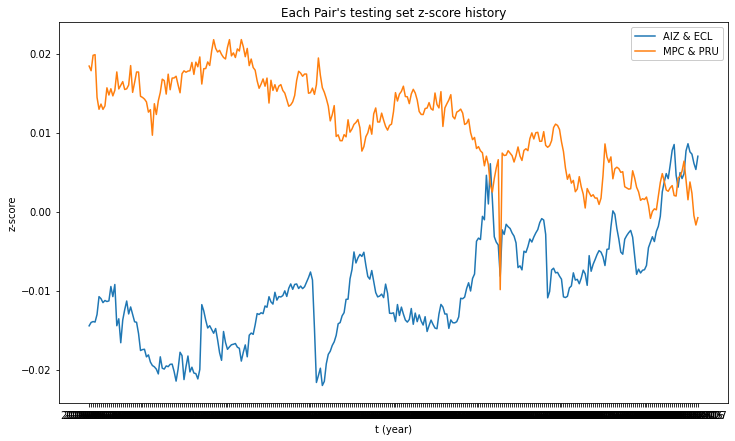

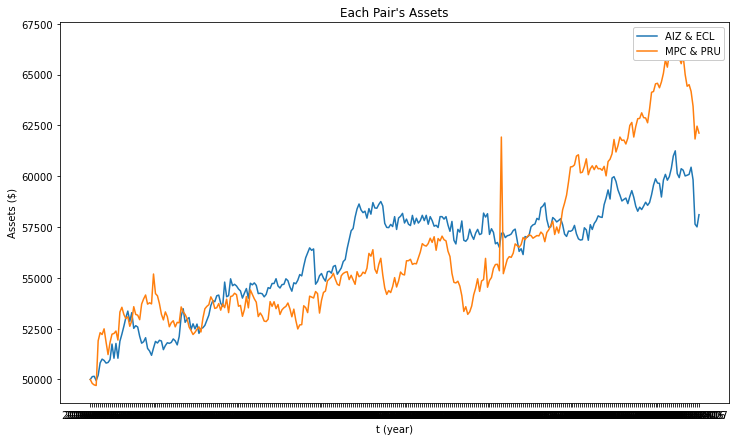

In [ ]:
# Read the z-score history list.
with open('z_score_history.npy', 'rb') as infile:
    z_score_list = np.load(infile)
    z_score_list = z_score_list[:2]

# Remove the initial 700 data. We generate the z-score after 700 days.
# price_list = training_set_price.to_numpy()[:, 700:]

a1 = processed.loc[processed.index.isin(['AIZ'])].to_numpy()[0]
b1 = processed.loc[processed.index.isin(['ECL'])].to_numpy()[0]
a2 = processed.loc[processed.index.isin(['MPC'])].to_numpy()[0]
b2 = processed.loc[processed.index.isin(['PRU'])].to_numpy()[0]
price_list = np.stack((a1, b1,a2,b2), axis=0)


# Initial money is $100000.
initial_money = 100000

z_score_list = z_score_list[:,950:]
price_list = price_list[:,950:]

# Run the backtesting code
BT = Backtesting(z_score_list, total_money = initial_money)
asset_per_pair = BT.backtesting(z_score_list, price_list)

# Plot the graphs about results
x = processed.columns[950:]

# Graph about each pair's z-score
plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s testing set z-score history')
plt.ylabel('z-score')
plt.xlabel('t (year)')
# for i, pair in enumerate(pairs_list):
#     plt.plot(x, z_score_list[i], label=str(pair))

plt.plot(x, z_score_list[0], label = 'AIZ & ECL')
plt.plot(x, z_score_list[1], label = 'MPC & PRU')
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_z_score.png')
plt.show()

# Graph about each pair's assets
plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (year)')
# for i, pair in enumerate(pairs_list):
#     plt.plot(x, asset_per_pair[i], label=str(pair))

plt.plot(x, asset_per_pair[0], label = 'AIZ & ECL')
plt.plot(x, asset_per_pair[1], label = 'MPC & PRU')

plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_assets.png')
plt.show()

# Graph about total asset
plt.figure(figsize=(12, 7))
plt.title('Total Assets')
plt.ylabel('Assets ($)')
plt.xlabel('t (year)')
total_asset = np.sum(asset_per_pair, axis=0)
plt.plot(x, total_asset)
plt.savefig('total_assets.png')
plt.show()

# Calculate the total earning
total_earning_ratio = total_asset[-1] / initial_money
print("Total earning ratio: " + str(total_earning_ratio))

# Save the total assets
total_asset_history = pd.DataFrame(
    total_asset,
    index=x,
    columns=['total assets']
)
total_asset_history.to_csv('total_asset_history.csv', index=True)